# Bitcoin Forecasting with Keras/Tensorflow

In [1]:
#Import Libraries

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
sns.set()
from keras.models import Sequential
from keras.layers import LSTM,Dense
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


In [ ]:
# Below code is for accessing Binance.com API. Registering with the site is required to access a key and security code.
# A CSV file has been provided (taken from the Binance API for Bitcoin) for convenience.

'''
from binance.client import Client

key = "" #Input personal Binance Key as string.
code = "" #Input personal Binance Security Code as string.

client = Client(key,code)

symbol = 'BTCUSDT'
BTC = client.get_historical_klines(symbol, Client.KLINE_INTERVAL_1DAY,  "1 Dec, 2016")
df_BTC = pd.DataFrame(BTC, columns= ['Open_Time','Open','High','Low','Close','Volume','Close_Time','Quote_Asset_Volume','Num_Trades','Taker_Buy_Base_Asset volume','Taker_Buy_Quote_Asset_Volume','IGNORE'])
df_BTC.to_csv('df_BTC.csv',index=False)
'''

In [40]:
df_BTC = pd.read_csv('.\\CSV_Files\\df_BTC.csv')
df_BTC['Open_Time'] = pd.to_datetime(df_BTC['Open_Time'], unit='ms')

In [3]:
BTC_org = df_BTC['Close']


In [4]:
BTC = df_BTC['Close']
BTC.head()

0    4285.08
1    4108.37
2    4139.98
3    4086.29
4    4016.00
Name: Close, dtype: float64

In [ ]:
BTC.shape

In [5]:
scl = MinMaxScaler()
#Scale the data
BTC = BTC.values.reshape(BTC.shape[0],1)
BTC.shape

(699, 1)

In [6]:
BTC = scl.fit_transform(BTC)
BTC

array([[0.06887551],
       [0.0577712 ],
       [0.05975754],
       [0.05638371],
       [0.05196674],
       [0.05347488],
       [0.05812561],
       [0.07081912],
       [0.06859901],
       [0.07216576],
       [0.07044209],
       [0.07526059],
       [0.08787807],
       [0.08584585],
       [0.0965128 ],
       [0.10342637],
       [0.0806302 ],
       [0.08295148],
       [0.05725214],
       [0.07398999],
       [0.08990715],
       [0.09442152],
       [0.06873223],
       [0.06722472],
       [0.05915366],
       [0.0640614 ],
       [0.06124934],
       [0.04748568],
       [0.        ],
       [0.03210956],
       [0.03304901],
       [0.03210893],
       [0.05316131],
       [0.0453083 ],
       [0.0446774 ],
       [0.02645341],
       [0.02556612],
       [0.0371367 ],
       [0.02959725],
       [0.04598131],
       [0.04356828],
       [0.06308927],
       [0.06192675],
       [0.06193869],
       [0.07474657],
       [0.07474468],
       [0.0748402 ],
       [0.070

In [89]:
#Divide data into train/test sets. 

def processData(data,lb):
    X,Y = [],[]
    for i in range(len(data)-lb-1):
        X.append(data[i:(i+lb),0])
        Y.append(data[(i+lb),0])
    return np.array(X),np.array(Y)

X,y = processData(BTC,10)  #10 day look-back slices
X_train,X_test = X[:-20],X[-20:]
y_train,y_test = y[:-20],y[-20:]

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(668, 10)
(20, 10)
(668,)
(20,)


In [90]:
#Reshape data for (Sample,Timestep,Features) 
X_train = X_train.reshape(len(X_train),1,X_train.shape[1])
X_test = X_test.reshape(len(X_test),1,X_test.shape[1])

In [91]:
X_train.shape

(668, 1, 10)

Build the model. Note that this model could benefit from further optimization/tweaking, this is intended as a first pass/intro to Keras.

In [92]:
model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(256))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

#Fit model with history to check for overfitting
history = model.fit(X_train,y_train,epochs=100,batch_size=16,shuffle=False)


Epoch 1/100
668/668 [==============================] - 38s 57ms/step - loss: 0.0349
Epoch 2/100
668/668 [==============================] - 2s 3ms/step - loss: 0.0070
Epoch 3/100
668/668 [==============================] - 2s 3ms/step - loss: 0.0034
Epoch 4/100
668/668 [==============================] - 2s 3ms/step - loss: 0.0030
Epoch 5/100
668/668 [==============================] - 2s 3ms/step - loss: 0.0029
Epoch 6/100
668/668 [==============================] - 2s 3ms/step - loss: 0.0027
Epoch 7/100
668/668 [==============================] - 2s 3ms/step - loss: 0.0026
Epoch 8/100
668/668 [==============================] - 2s 3ms/step - loss: 0.0024
Epoch 9/100
668/668 [==============================] - 2s 3ms/step - loss: 0.0022
Epoch 10/100
668/668 [==============================] - 2s 3ms/step - loss: 0.0020
Epoch 11/100
668/668 [==============================] - 2s 3ms/step - loss: 0.0018
Epoch 12/100
668/668 [==============================] - 2s 3ms/step - loss: 0.0016
Epoch 13/10

668/668 [==============================] - 2s 3ms/step - loss: 9.8439e-04
Epoch 100/100
668/668 [==============================] - 2s 3ms/step - loss: 9.9504e-04


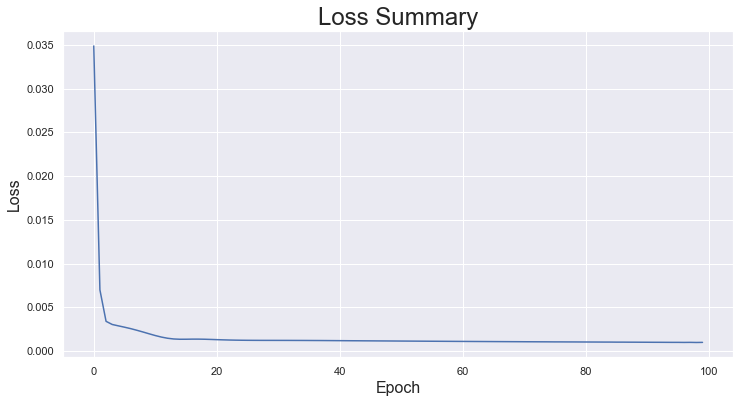

In [99]:
plt.figure(figsize=(12,6))

plt.plot(history.history['loss'])

plt.title("Loss Summary", fontsize=24)
plt.xlabel("Epoch", fontsize=16)
plt.ylabel("Loss", fontsize=16)

plt.show()

### Forecast next 20 days.

Use a "Rolling Forecast" approach for predicting the next 20 days (same as the test period). This means that the predicted y values for each day will not be used to forecast future y values - it is assumed that this model would be used day-by-day. For example - the first day following the train set would be predicted, and then compared to the actual y value from the y_test set. The actual value would be known and applied in predicting the second day, as opposed to the predicted value, and so on.

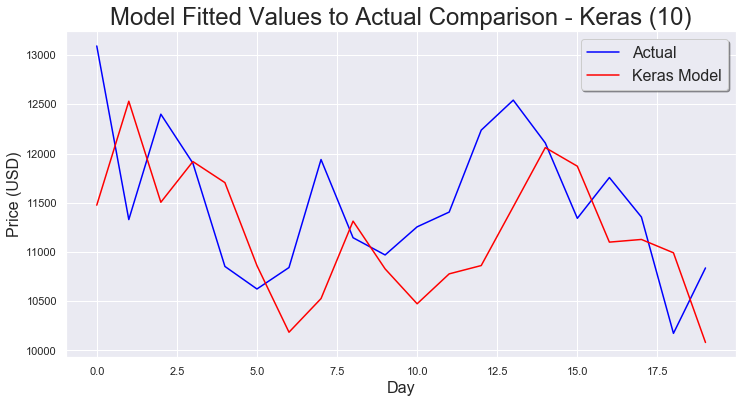

In [101]:
Xt = model.predict(X_test)

plt.figure(figsize=(12,6))
plt.plot(scl.inverse_transform(y_test.reshape(-1,1)), color='blue', label='Actual')
plt.plot(scl.inverse_transform(Xt), color='red', label='Keras Model')

plt.legend(loc='best', fontsize=16, shadow=True, fancybox=True)
plt.title("Model Fitted Values to Actual Comparison - Keras (10)", fontsize=24)
plt.xlabel("Day", fontsize=16)
plt.ylabel("Price (USD)", fontsize=16)

plt.show()